In this notebook, we'll be exploring how to use BERT with fastai for sentence classification.

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

In [2]:
from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [4]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=1,
    use_fp16=False,
    bs=4,
    discriminative=False,
    max_seq_len=128,
)

We'll be using the pytorch-pretrained-bert package, so install it if you do not have it yet!

BERT requires a special wordpiece tokenizer and a vocabulary to go along with that. Thankfully, the pytorch-pretrained-bert package provides all of that within the handy `BertTokenizer` class.

# Data

In [5]:
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


FastAI has its own conventions for handling tokenization, so we'll need to wrap the tokenizer within a different class. This is a bit confusing but shouldn't be that much of a hassle.

Notice we add the \[CLS] and \[SEP] special tokens to the start and end of the sequence here.


In [6]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around BertTokenizer to be compatible with fast.ai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

Slightly confusingly, we further need to wrap the tokenizer above in a `Tokenizer` object. 

In [7]:
fastai_tokenizer = Tokenizer(tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), pre_rules=[], post_rules=[])

Now, we need to make sure fastai uses the same mapping from wordpiece to integer as BERT originally did. Again, fastai has its own conventions on vocabulary so we'll be passing the vocabulary internal to the `BertTokenizer` and constructing a fastai `Vocab` object to use for preprocessing.

In [8]:
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

Now we have all the pieces we need to make BERT work with fastai! We'll load the data into dataframes and construct a validation set.

In [9]:
from sklearn.model_selection import train_test_split

DATA_ROOT = Path("..") / "data" / "jigsaw"

train, test = [pd.read_csv(DATA_ROOT / fname) for fname in ["train.csv", "test.csv"]]
train, val = train_test_split(train)

if config.testing:
    train = train.head(1024)
    val = val.head(1024)
    test = test.head(1024)

Now, we can build the databunch using the tokenizer and vocabulary we build above. Notice we're passing the `include_bos=False` and `include_eos=False` options. This is to prevent fastai from adding its own SOS/EOS tokens that will interfere with BERT's SOS/EOS tokens.

In [10]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

databunch = TextDataBunch.from_df(".", train, val, test,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="comment_text",
                  label_cols=label_cols,
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

Alternatively, we can pass our own list of Preprocessors to the databunch (this is effectively what is happening behind the scenes)

In [11]:
class BertTokenizeProcessor(TokenizeProcessor):
    def __init__(self, tokenizer):
        super().__init__(tokenizer=tokenizer, include_bos=False, include_eos=False)

class BertNumericalizeProcessor(NumericalizeProcessor):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, vocab=Vocab(list(bert_tok.vocab.keys())), **kwargs)

def get_bert_processor(tokenizer:Tokenizer=None, vocab:Vocab=None):
    """
    Constructing preprocessors for BERT
    We remove sos/eos tokens since we add that ourselves in the tokenizer.
    We also use a custom vocabulary to match the numericalization with the original BERT model.
    """
    return [BertTokenizeProcessor(tokenizer=tokenizer),
            NumericalizeProcessor(vocab=vocab)]

To use our own custom preprocessors, we'll need to modify the `from_df` method to call the function above. Not the cleanest code but it will suffice.

In [12]:
class BertDataBunch(TextDataBunch):
    @classmethod
    def from_df(cls, path:PathOrStr, train_df:DataFrame, valid_df:DataFrame, test_df:Optional[DataFrame]=None,
                tokenizer:Tokenizer=None, vocab:Vocab=None, classes:Collection[str]=None, text_cols:IntsOrStrs=1,
                label_cols:IntsOrStrs=0, label_delim:str=None, **kwargs) -> DataBunch:
        "Create a `TextDataBunch` from DataFrames."
        p_kwargs, kwargs = split_kwargs_by_func(kwargs, get_bert_processor)
        # use our custom processors while taking tokenizer and vocab as kwargs
        processor = get_bert_processor(tokenizer=tokenizer, vocab=vocab, **p_kwargs)
        if classes is None and is_listy(label_cols) and len(label_cols) > 1: classes = label_cols
        src = ItemLists(path, TextList.from_df(train_df, path, cols=text_cols, processor=processor),
                        TextList.from_df(valid_df, path, cols=text_cols, processor=processor))
        src = src.label_for_lm() if cls==TextLMDataBunch else src.label_from_df(cols=label_cols, classes=classes)
        if test_df is not None: src.add_test(TextList.from_df(test_df, path, cols=text_cols))
        return src.databunch(**kwargs)

In [13]:
# this will produce a virtually identical databunch to the code above
# databunch = BertDataBunch.from_df(".", train, val, test,
#                   tokenizer=fastai_tokenizer,
#                   vocab=fastai_bert_vocab,
#                   text_cols="comment_text",
#                   label_cols=label_cols,
#                   bs=config.bs,
#                   collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
#              )

# Model

Now with the data in place, we will prepare the model and loss functions. Again, the pytorch-pretrained-bert package gives us a sequence classifier based on BERT straight out of the box.

In [14]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=6)

Since this is a multilabel classification problem, we're using `BCEWithLogitsLoss`

In [15]:
loss_func = nn.BCEWithLogitsLoss()

And now we can build the `Learner`.

In [16]:
from fastai.callbacks import *

learner = Learner(
    databunch, bert_model,
    loss_func=loss_func,
)

And we're done! All the rest is fastai magic. For example, you can use half-precision training simply by calling `learner.to_fp16()`

In [17]:
if config.use_fp16: learner = learner.to_fp16()

We can also use the learning rate finder.

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


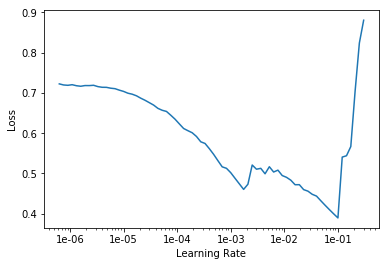

In [19]:
learner.recorder.plot()

And now to actually train the model.

In [20]:
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,time
0,0.397212,0.235468,02:23


See how simple that was?

# Predictions

Now to generate predictions. This is where you can get tripped up because the `databunch` does not load data in sorted order. So we'll have to do reorder the generated predictions to match their original order.

In [21]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [22]:
test_preds = get_preds_as_nparray(DatasetType.Test)

You can generate a submission if you like, though you'll probably want to use a different set of configurations.

In [24]:
# sample_submission = pd.read_csv(DATA_ROOT / "sample_submission.csv")
# if config.testing: sample_submission = sample_submission.head(test.shape[0])
# sample_submission[label_cols] = test_preds
# sample_submission.to_csv("predictions.csv", index=False)